In [71]:
pip install SPARQLWrapper fuzzywuzzy xlsxwriter
pip install openai==0.28
pip install language_tool_python
pip install transformers
pip install python-Levenshtein
pip install torch
pip install --upgrade nltk pandas scikit-learn
pip install sentence-transformers

Note: you may need to restart the kernel to use updated packages.


In [16]:
import requests
from SPARQLWrapper import SPARQLWrapper, JSON
from collections import Counter
import xlsxwriter
import sys
import pandas as pd
from collections import Counter
import language_tool_python
from textstat import textstat
import re


sys.path.insert(0, '/Users/hamzaiqbal/Documents/Master_Study/Thesis/code')

# Function to unify properties using your synonym dictionary
from functions_sum_strict import prop_functions

def unify_properties(property_uri):
    """
    Unify RDF properties based on a predefined dictionary.
    """
    for key, synonyms in prop_functions.items():
        if property_uri in synonyms:
            return key  # Return unified property name
    return property_uri.split('/')[-1]  # Fallback to the last segment of the URI

def query_dbpedia(entity_uri):
    """
    Query DBpedia for RDF data related to a given entity URI.
    """
    sparql = SPARQLWrapper("https://dbpedia.org/sparql")
    query = f"""
    SELECT ?property ?value
    WHERE {{
        <{entity_uri}> ?property ?value .
        FILTER(
            !isLiteral(?value) || (lang(?value) = "" || lang(?value) = "en")
        )
    }}
    """
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    
    return results["results"]["bindings"]

def filter_relevant_data(results):
    """
    Filter RDF results to include only relevant data based on property-value pairs.
    """
    relevant_results = []
    for result in results:
        property_uri = result["property"]["value"]
        value = result["value"]["value"]

        # Skip irrelevant properties
        if any(skip in property_uri for skip in [
            "owl#sameAs", "prov#wasDerivedFrom", "isPrimaryTopicOf", "wikiPageExternalLink", "url", "rdf-schema#comment", "abstract",
            "shortDescription", "dfeno", "dms", "freeLabel", "imageWidth", "current", "logosize", "imageSize", "pixels", "fontcolor",
            "yearsActive", "isbn", "oclc", "caption","wikiPageRevisionID","rdf-schema#label","alt","bg","image","wikiPageLength",
            "wikiPageID","bordercolor","fg","years","year","columns","width","date","filename","id","wikt","seal","img","wgs84_pos#lat",
            "wgs84_pos#long", "wgs84_pos#geometry","utcOffset", "utcOffset1Dst", "utcOffset2Dst", "populationAsOf","isoCode","right",
            "text","statRef","divLink"
            
        ]):
            continue

        # Skip values that are URLs
        if "http://" in value or "https://" in value:
            continue

        # Include relevant properties and values
        relevant_results.append((property_uri, value))

    return relevant_results


def count_frequencies(rdf_data):
    """
    Count the frequency of unified property-value pairs.
    'Entity' column is added to associate the data with the entity name.
    """
    frequency_counter = Counter()
    
    for property_uri, value, entity_name in rdf_data:
        unified_property = unify_properties(property_uri)

        # For properties like areaLand, areaWater, etc., we might want to sum or merge the values
        if unified_property in ["areaLand", "areaWater", "areaTotal", "elevationMinFt", "elevationMinM"]:
            # Attempt to convert value to float for summing
            try:
                value = float(value)
            except ValueError:
                continue  # Skip if the value cannot be converted to float

        # Add entity information to the frequency count
        frequency_counter[(unified_property, value, entity_name)] += 1
    
    return frequency_counter


def save_to_excel(frequency_data, file_name="frequency_analysis.xlsx"):
    """
    Save frequency data to an Excel file, ensuring one unique property per entity.
    - For numeric data: Keep only the latest updated value.
    - For text data: Concatenate all values of the repeated property as a single entry.
    - If a property has no valid value, it is removed.
    - If a property is a single alphabetical character (e.g., 'b', 'q'), it is removed.
    """
    workbook = xlsxwriter.Workbook(file_name)
    worksheet = workbook.add_worksheet()

    # Write headers
    worksheet.write(0, 0, "Property")
    worksheet.write(0, 1, "Value")
    worksheet.write(0, 2, "Frequency")
    worksheet.write(0, 3, "Entity")

    # Helper dictionary to store unique properties per entity
    unique_properties_per_entity = {}

    for (property, value, entity), frequency in frequency_data.items():
        key = (entity, property)  # Group by entity and property

        # **Skip empty values** (None, empty string, whitespace-only)
        if value is None or (isinstance(value, str) and not value.strip()):
            continue  # Ignore empty values and do not store them

        # **Skip single-character alphabetical properties**
        if len(property) == 1 and property.isalpha():
            continue  # Ignore single-letter properties

        if key not in unique_properties_per_entity:
            unique_properties_per_entity[key] = (value, frequency)
        else:
            existing_value, current_frequency = unique_properties_per_entity[key]

            # **Check if the value is numeric**
            if isinstance(value, (int, float)) or (isinstance(value, str) and value.replace('.', '', 1).isdigit()):
                # If numeric, replace with the latest value and update frequency
                unique_properties_per_entity[key] = (value, current_frequency + frequency)
            else:
                # If text, concatenate without leading commas
                if existing_value:
                    new_value = f"{existing_value}, {value}"
                else:
                    new_value = value  # No leading comma if first value
                
                unique_properties_per_entity[key] = (new_value, current_frequency + frequency)

    # **Remove empty properties** before writing to Excel
    filtered_data = [
        (property, value, frequency, entity)
        for (entity, property), (value, frequency) in unique_properties_per_entity.items()
        if (isinstance(value, str) and value.strip()) or isinstance(value, (int, float))  # Ensure value is valid
    ]

    # Write filtered frequency data to the Excel file
    row = 1
    for property, value, frequency, entity in filtered_data:
        worksheet.write(row, 0, property)
        worksheet.write(row, 1, value)
        worksheet.write(row, 2, frequency)
        worksheet.write(row, 3, entity)
        row += 1

    workbook.close()
    print(f"Results saved to {file_name}")
    return filtered_data

def query_multiple_entities(entity_uris):
    """
    Query DBpedia for RDF data related to a list of entity URIs.
    """
    all_results = []
    for entity_uri in entity_uris:
        # Extract entity name from URI
        entity_name = entity_uri.split("/")[-1]  
        results = query_dbpedia(entity_uri)
        relevant_results = filter_relevant_data(results)
        # Add entity to results
        all_results.extend([(property, value, entity_name) for property, value in relevant_results])  
    return all_results

def distinguish_analysis_table_v2(frequency_data):
    """
    Perform a refined distinguish analysis, identifying unique and shared properties
    and differentiating values across entities.
    """
    # Organize properties and values by entity
    entity_properties = {}
    for (property, value, entity), _ in frequency_data.items():
        if entity not in entity_properties:
            entity_properties[entity] = {}
        if property not in entity_properties[entity]:
            entity_properties[entity][property] = []
        entity_properties[entity][property].append(value)

    all_entities = list(entity_properties.keys())
    all_properties = set()
    for props in entity_properties.values():
        all_properties.update(props.keys())

    # Build the table data
    table_data = []
    for property in sorted(all_properties):
        row = [property]
        unique_values = {}  # Track unique values for highlighting
        shared = False

        for entity in all_entities:
            if property in entity_properties[entity]:
                values = entity_properties[entity][property]
                human_readable = ", ".join(map(str, values))
                row.append(f"{human_readable}")
                unique_values[entity] = set(values)
            else:
                row.append("Not available")

        # Check for shared properties with differing values
        if len(unique_values) > 1:
            shared = True
            differing_values = {entity: vals for entity, vals in unique_values.items()}
            row.append(f"Differing values: {differing_values}")
        else:
            row.append("Unique to entity")

        table_data.append(row)

    return all_entities, table_data

def save_distinguish_analysis_table_v2(entities, table_data, file_name="distinguish_analysis_v2.xlsx"):
    """
    Save the refined distinguish analysis as a comparison table in Excel with highlights.
    """
    workbook = xlsxwriter.Workbook(file_name)
    worksheet = workbook.add_worksheet("Refined Comparison Table")

    # Write the header row
    worksheet.write(0, 0, "Property")
    for col, entity in enumerate(entities, start=1):
        worksheet.write(0, col, entity)
    worksheet.write(0, len(entities) + 1, "Analysis Notes")

    # Write the data rows
    for row_idx, row in enumerate(table_data, start=1):
        for col_idx, cell in enumerate(row):
            worksheet.write(row_idx, col_idx, cell)

    # Conditional formatting (e.g., highlight notes with "Differing" or "Unique")
    format_diff = workbook.add_format({'bg_color': '#FFEB9C'})
    format_unique = workbook.add_format({'bg_color': '#C6EFCE'})
    worksheet.conditional_format(1, len(entities) + 1, len(table_data), len(entities) + 1, 
                                  {'type': 'text', 'criteria': 'containing', 
                                   'value': 'Differing', 'format': format_diff})
    worksheet.conditional_format(1, len(entities) + 1, len(table_data), len(entities) + 1, 
                                  {'type': 'text', 'criteria': 'containing', 
                                   'value': 'Unique', 'format': format_unique})

    workbook.close()
    print(f"Refined distinguish analysis table saved to {file_name}")

def generate_prompt(filtered_data, file_name="structured_prompt.txt"):
    """
    Prompt Generation in text file based on frequency data
    """
    # Create a list to store the lines of the output prompt
    prompt_lines = []

    # Add the introductory text at the top
    intro_text = """Create a concise, human-readable summary comparing the following entities. Focus on their key characteristics,
    differences, and notable commonalities, based on the provided data. The text should resemble a short encyclopedia entry, highlighting
    their unique features and important similarities. Exclude any speculative or unverifiable facts. Provide the summary in a
    well-structured and clear format."""
    prompt_lines.append(intro_text)
    prompt_lines.append("")  # Add a blank line after the introduction for readability

    # Group data by entity and generate the prompt
    current_entity = None
    for property, value, frequency, entity in filtered_data:
        if entity != current_entity:
            # Print the entity name before its properties
            if current_entity is not None:
                prompt_lines.append("")  # Add a blank line between entities
            prompt_lines.append(f"Entity: {entity}")
            current_entity = entity
        
        # Format each line with property, value, and frequency
        prompt_lines.append(f"{property}: {value} (Frequency: {frequency})")

    # Join all lines into a single string with newlines
    full_prompt = "\n".join(prompt_lines)

    # Write the full prompt to a text file
    with open(file_name, "w") as file:
        file.write(full_prompt)
    
    print(f"Structured prompt saved to {file_name}")


entity_uris = [
    "http://dbpedia.org/resource/Alabama",
     "http://dbpedia.org/resource/Florida",
     "http://dbpedia.org/resource/Delaware"
    
]

# Query DBpedia for multiple entities
all_rdf_results = query_multiple_entities(entity_uris)

# Perform frequency analysis on combined data
frequency_data = count_frequencies(all_rdf_results)

# Save the frequency results to Excel
filtered_data = save_to_excel(frequency_data, "frequency_analysis.xlsx")

# Generate a structured prompt for summarization
generate_prompt(filtered_data, "structured_prompt.txt")

# Perform refined distinguish analysis and save the results
entities, table_data = distinguish_analysis_table_v2(frequency_data)
save_distinguish_analysis_table_v2(entities, table_data, "distinguish_analysis.xlsx")
#print(frequency_data)

Results saved to frequency_analysis.xlsx
Structured prompt saved to structured_prompt.txt
Refined distinguish analysis table saved to distinguish_analysis.xlsx


/var/folders/cq/8yfr3h_d5mj9zfzt2ypw4f100000gn/T/ipykernel_1571/2649019975.py:77: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=grammar_scores, ax=axes[0, 0], palette="Blues_d")
/var/folders/cq/8yfr3h_d5mj9zfzt2ypw4f100000gn/T/ipykernel_1571/2649019975.py:81: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(models, rotation=45, ha="right")
/var/folders/cq/8yfr3h_d5mj9zfzt2ypw4f100000gn/T/ipykernel_1571/2649019975.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models, y=readability_scores, ax=axes[0, 1], palette="Greens_d")
/var/folders/cq/8yfr3h_d5mj9zfzt2ypw4f100

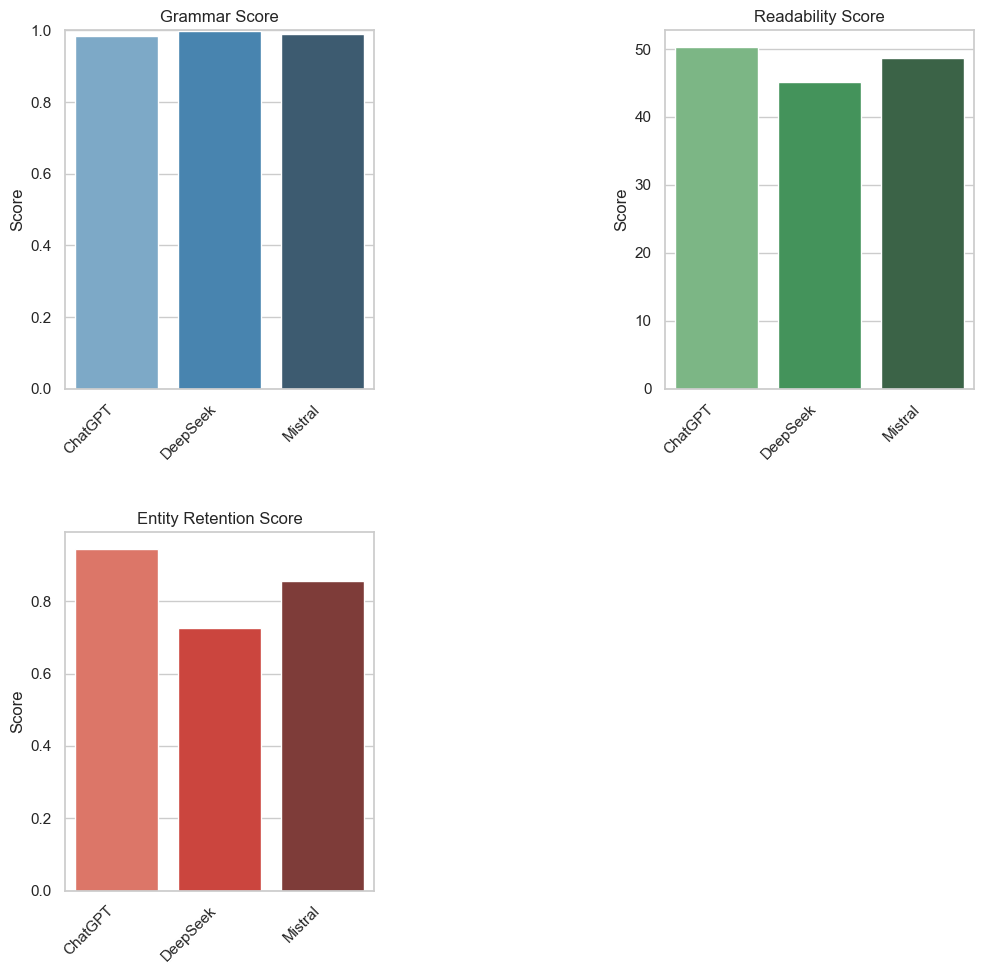

In [25]:
# Ensure this is at the top of your notebook
%matplotlib inline

import pandas as pd
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from fuzzywuzzy import fuzz
import language_tool_python
import textstat

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Load RDF frequency analysis data
def read_frequency_data(file_name):
    df = pd.read_excel(file_name)
    return df[['Property', 'Value']].astype(str)  # Ensure strings for processing

# Load summary text
def load_summary(file_path):
    with open(file_path, "r", encoding="utf-8") as file:
        return file.read()

# Compute Entity Retention Score
def compute_entity_retention(rdf_df, summary):
    rdf_entities = set(rdf_df['Value'])
    summary_tokens = word_tokenize(summary)

    retained_entities = []
    for entity in rdf_entities:
        for token in summary_tokens:
            if fuzz.partial_ratio(entity.lower(), token.lower()) > 80:  # Threshold for fuzzy matching
                retained_entities.append(entity)
                break

    return len(set(retained_entities)) / len(rdf_entities) if rdf_entities else 0

# Assess text quality (Grammar & Readability)
def assess_text_quality(summary):
    tool = language_tool_python.LanguageTool('en-US')
    matches = tool.check(summary)
    grammar_score = 1 - (len(matches) / max(1, len(summary.split())))
    readability_score = textstat.flesch_reading_ease(summary)
    return grammar_score, readability_score

# Main assessment function
def assess_summaries(summary_files, frequency_data_file):
    rdf_data = read_frequency_data(frequency_data_file)

    results = {}
    for model_name, file_path in summary_files.items():
        summary_text = load_summary(file_path)
        entity_retention_score = compute_entity_retention(rdf_data, summary_text)
        grammar_score, readability_score = assess_text_quality(summary_text)

        results[model_name] = {
            "Grammar Score": grammar_score,
            "Readability Score": readability_score,
            "Entity Retention Score": entity_retention_score
        }

    return results

# Visualization function
def plot_results(results):
    models = list(results.keys())
    grammar_scores = [results[m]["Grammar Score"] for m in models]
    readability_scores = [results[m]["Readability Score"] for m in models]
    entity_scores = [results[m]["Entity Retention Score"] for m in models]

    # Create a figure with three subplots arranged in a square layout
    fig, axes = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'height_ratios': [1, 1], 'width_ratios': [1, 1]})

    # Plot Grammar Score
    sns.barplot(x=models, y=grammar_scores, ax=axes[0, 0], palette="Blues_d")
    axes[0, 0].set_title("Grammar Score", fontsize=12)
    axes[0, 0].set_ylabel("Score")
    axes[0, 0].set_ylim(0, 1)
    axes[0, 0].set_xticklabels(models, rotation=45, ha="right")

    # Plot Readability Score
    sns.barplot(x=models, y=readability_scores, ax=axes[0, 1], palette="Greens_d")
    axes[0, 1].set_title("Readability Score", fontsize=12)
    axes[0, 1].set_ylabel("Score")
    axes[0, 1].set_xticklabels(models, rotation=45, ha="right")

    # Plot Entity Retention Score
    sns.barplot(x=models, y=entity_scores, ax=axes[1, 0], palette="Reds_d")
    axes[1, 0].set_title("Entity Retention Score", fontsize=12)
    axes[1, 0].set_ylabel("Score")
    axes[1, 0].set_xticklabels(models, rotation=45, ha="right")

    # Center the bottom plot
    axes[1, 0].set_position([0.25, 0.1, 0.5, 0.35])

    # Hide the unused subplot
    axes[1, 1].axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(hspace=0.4)
    plt.show()

# Example usage
summary_files = {
    "ChatGPT": "summary_chatgpt.txt",
    "DeepSeek": "summary_deepseek.txt",
    "Mistral": "summary_mistral.txt"
}

frequency_data_file = "frequency_analysis.xlsx"
results = assess_summaries(summary_files, frequency_data_file)
plot_results(results)


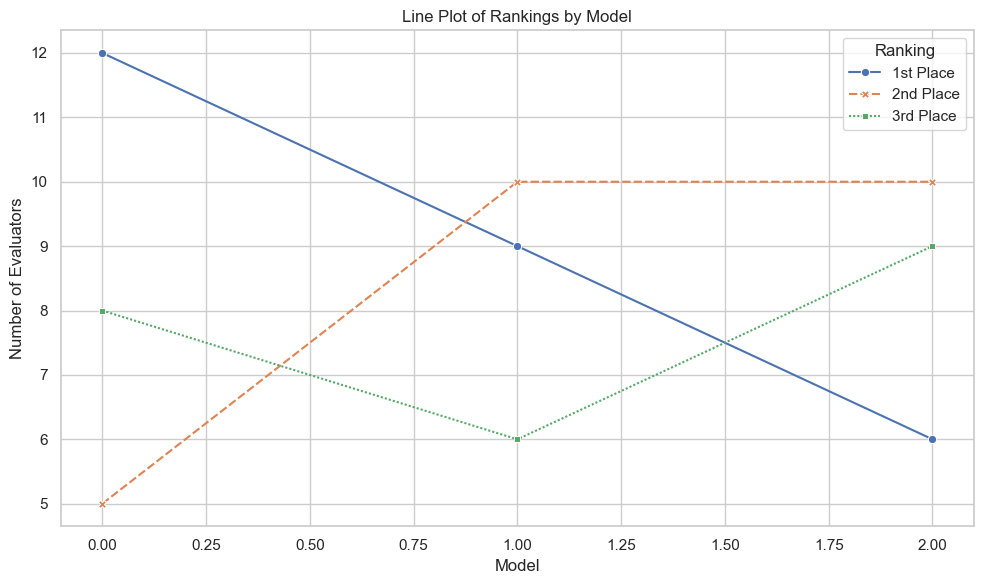

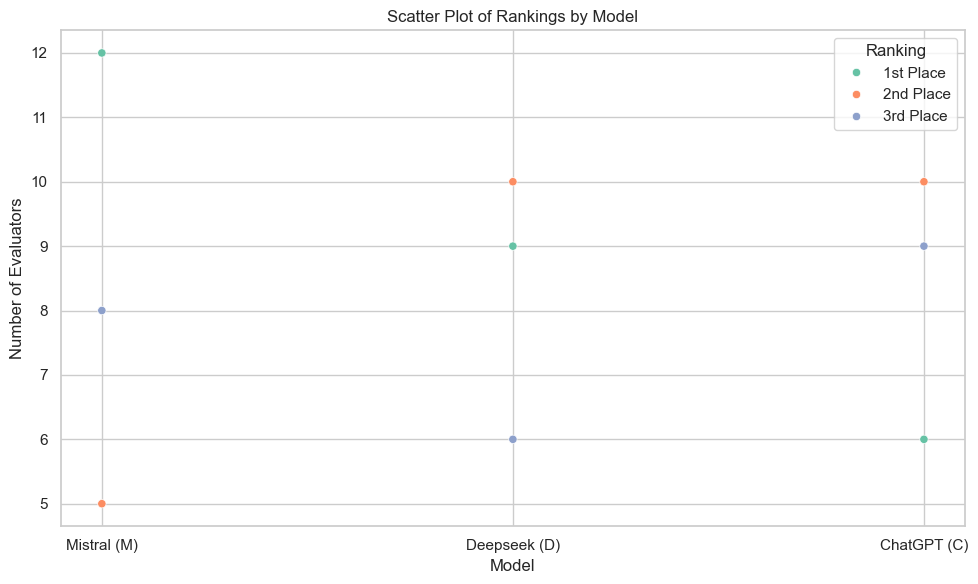

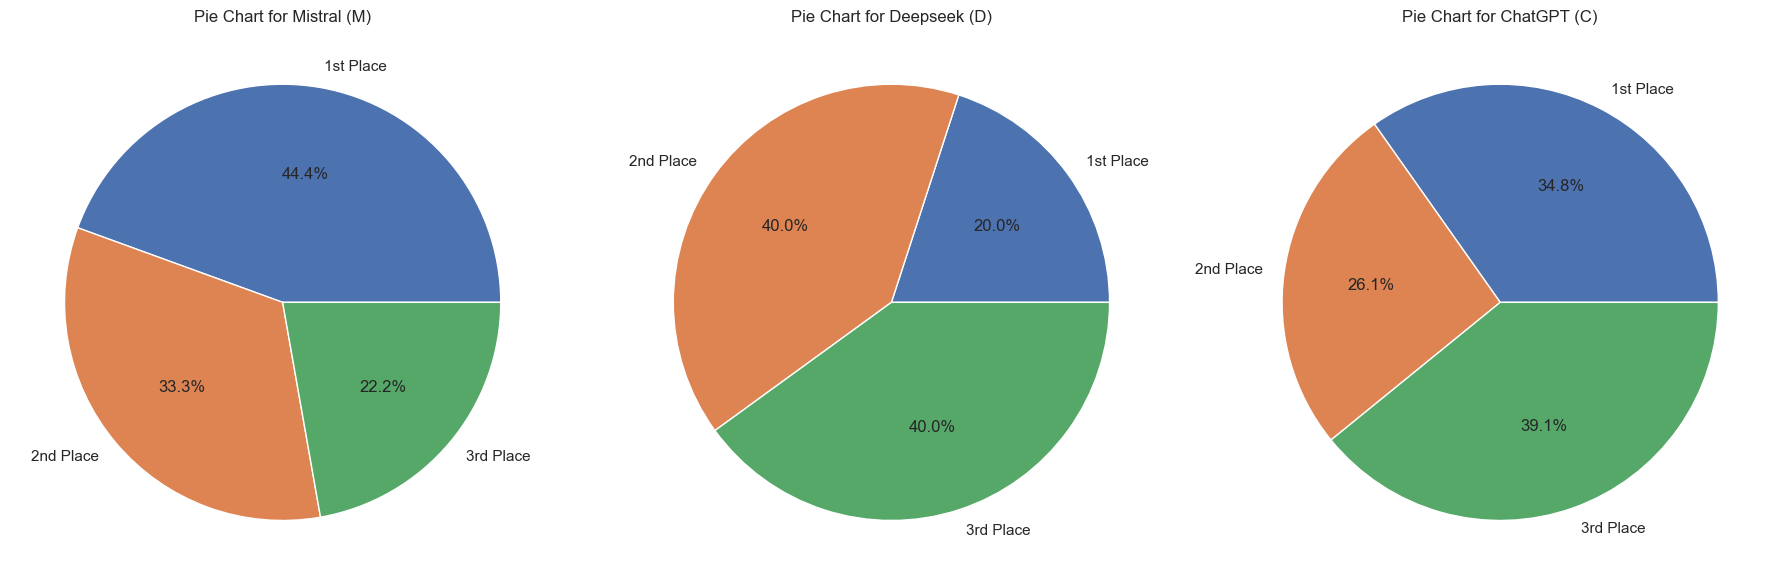

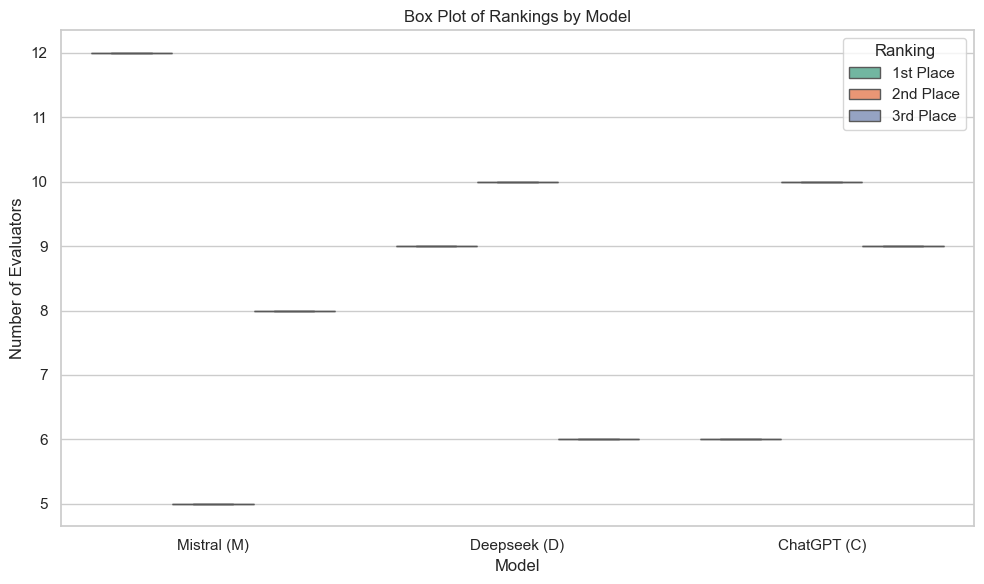

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Data for the ranking distribution
models = ['Mistral (M)', 'Deepseek (D)', 'ChatGPT (C)']
first_place = [12, 9, 6]
second_place = [5, 10, 10]
third_place = [8, 6, 9]

# Create a DataFrame for the ranking data
ranking_df = pd.DataFrame({
    "Model": models,
    "1st Place": first_place,
    "2nd Place": second_place,
    "3rd Place": third_place
})

# Melt the DataFrame for easier plotting with seaborn
melted_df = ranking_df.melt(id_vars=['Model'], value_vars=['1st Place', '2nd Place', '3rd Place'],
                            var_name='Ranking', value_name='Count')

# # Bar Plot
# plt.figure(figsize=(10, 6))
# sns.barplot(data=melted_df, x='Model', y='Count', hue='Ranking', palette='Set2')
# plt.title('Distribution of Rankings by Model')
# plt.xlabel('Model')
# plt.ylabel('Number of Evaluators')
# plt.legend(title='Ranking')
# plt.tight_layout()
# plt.show()

# Line Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=ranking_df, markers=True)
plt.title('Line Plot of Rankings by Model')
plt.xlabel('Model')
plt.ylabel('Number of Evaluators')
plt.legend(title='Ranking')
plt.tight_layout()
plt.show()

# Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=melted_df, x='Model', y='Count', hue='Ranking', palette='Set2')
plt.title('Scatter Plot of Rankings by Model')
plt.xlabel('Model')
plt.ylabel('Number of Evaluators')
plt.legend(title='Ranking')
plt.tight_layout()
plt.show()

# # Histogram
# plt.figure(figsize=(10, 6))
# sns.histplot(data=melted_df, x='Count', hue='Ranking', multiple='stack', palette='Set2', bins=10)
# plt.title('Histogram of Rankings by Model')
# plt.xlabel('Number of Evaluators')
# plt.ylabel('Frequency')
# plt.legend(title='Ranking')
# plt.tight_layout()
# plt.show()

# Pie Chart for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Transpose the DataFrame to iterate over columns
for ax, model, data in zip(axes, models, ranking_df.set_index('Model').T.values):
    ax.pie(data, labels=['1st Place', '2nd Place', '3rd Place'], autopct='%1.1f%%')
    ax.set_title(f'Pie Chart for {model}')

plt.tight_layout()
plt.show()



# Box Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=melted_df, x='Model', y='Count', hue='Ranking', palette='Set2')
plt.title('Box Plot of Rankings by Model')
plt.xlabel('Model')
plt.ylabel('Number of Evaluators')
plt.legend(title='Ranking')
plt.tight_layout()
plt.show()


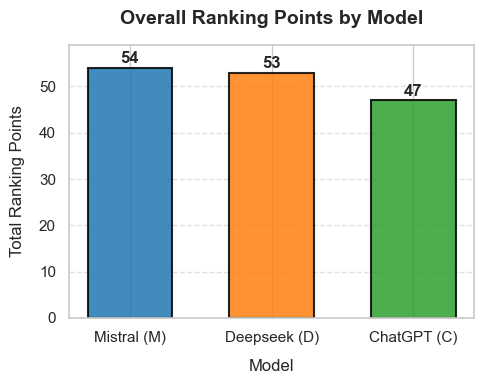

In [39]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Data for the ranking distribution
models = ['Mistral (M)', 'Deepseek (D)', 'ChatGPT (C)']
first_place = [12, 9, 6]
second_place = [5, 10, 10]
third_place = [8, 6, 9]

# Create a DataFrame for the ranking data
ranking_df = pd.DataFrame({
    "Model": models,
    "1st Place": first_place,
    "2nd Place": second_place,
    "3rd Place": third_place
})

# Calculate total ranking points
ranking_df['Total Points'] = ranking_df['1st Place'] * 3 + ranking_df['2nd Place'] * 2 + ranking_df['3rd Place'] * 1

# Plot the total ranking points
plt.figure(figsize=(5, 4))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green

bars = plt.bar(
    ranking_df['Model'],
    ranking_df['Total Points'],
    color=colors,
    edgecolor='black',
    linewidth=1.5,
    alpha=0.85,
    width=0.6
)

# Title and Labels
plt.title('Overall Ranking Points by Model', fontsize=14, fontweight='bold', pad=15)
plt.xlabel('Model', fontsize=12, labelpad=10)
plt.ylabel('Total Ranking Points', fontsize=12, labelpad=10)
plt.ylim(0, max(ranking_df['Total Points']) + 5)

# Gridlines
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with total points
for bar in bars:
    plt.text(
        bar.get_x() + bar.get_width()/2,
        bar.get_height() + 1,
        str(int(bar.get_height())),
        ha='center',
        fontsize=12,
        fontweight='bold'
    )

# Get the current working directory
current_directory = os.getcwd()

# Define the output path
output_path = os.path.join(current_directory, 'ranking_points.png')

# Save the plot as a PNG file
plt.savefig(output_path, format='png', bbox_inches='tight')

# Show the plot
plt.tight_layout()
plt.show()
